<a href="https://colab.research.google.com/github/ramkumarravi49/DA6401_A1/blob/main/A1_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q1

In [2]:
import numpy as np
import wandb
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

# Load dataset
(X, y), (X_test, y_test) = fashion_mnist.load_data()

# Class labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Initialize wandb for logging
#wandb.init(project="dl_assignment1", entity="ee17b154tony", name="assignment_1_log_images")

# Select one example per class from the raw data
example_indices = [np.where(y == i)[0][0] for i in range(len(class_names))]
example_images = [X[idx] for idx in example_indices]
example_captions = [class_names[y[idx]] for idx in example_indices]

# Log raw sample images to wandb
#wandb.log({"Raw Sample Images": [wandb.Image(img, caption=cap) for img, cap in zip(example_images, example_captions)]})

## Flatten and Noramalize

In [3]:
# Reshape data to flatten images
X = X.reshape(X.shape[0], -1) / 255.0
X_test = X_test.reshape(X_test.shape[0], -1) / 255.0

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Dataset statistics
M, num_features = X_train.shape
Mval = X_val.shape[0]
Mtest = X_test.shape[0]
num_classes = len(np.unique(y_train))

print(f"Training set size: {M}")
print(f"Validation set size: {Mval}")
print(f"Test set size: {Mtest}")
print(f"Number of classes: {num_classes}")
print(f"Features per example: {num_features}")

Training set size: 54000
Validation set size: 6000
Test set size: 10000
Number of classes: 10
Features per example: 784


## Encoding
- one hot enconding

In [4]:
# One-hot encode labels
y_train_one_hot = np.zeros((num_classes, M))
y_train_one_hot[y_train, np.arange(M)] = 1
y_val_one_hot = np.zeros((num_classes, Mval))
y_val_one_hot[y_val, np.arange(Mval)] = 1
y_test_one_hot = np.zeros((num_classes, Mtest))
y_test_one_hot[y_test, np.arange(Mtest)] = 1

# Transpose data for easier manipulation in models
X_train, X_val, X_test, X = X_train.T, X_val.T, X_test.T, X.T

# Define model parameters
input_nodes, output_nodes = num_features, num_classes


# Activation _ Helper __ Fn

In [5]:
class Sigmoid:
    @staticmethod
    def function(x):
        return 1. / (1. + np.exp(-x))

    @staticmethod
    def derivative(x):
        return Sigmoid.function(x) * (1 - Sigmoid.function(x))

class Relu:
    @staticmethod
    def function(x):
        return np.maximum(0, x)

    @staticmethod
    def derivative(x):
        return (x > 0).astype(float)

class Tanh:
    @staticmethod
    def function(x):
        return np.tanh(x)

    @staticmethod
    def derivative(x):
        return 1 - (np.tanh(x) ** 2)

class Softmax:
    @staticmethod
    def function(x):
        exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))
        return exp_x / np.sum(exp_x, axis=0, keepdims=True)

    @staticmethod
    def derivative(x):
        return Softmax.function(x) * (1 - Softmax.function(x))

In [6]:
# Function to initialize weights and biases
def Init_Parameters(layer_dims, init_mode="xavier"):
    np.random.seed(42)
    parameters = {}  # Renamed params to parameters
    prev_updates = {}
    for i in range(1, len(layer_dims)):
        if init_mode == 'random_normal':
            parameters[f"W{i}"] = np.random.randn(layer_dims[i], layer_dims[i-1]) * 0.01
        elif init_mode == 'random_uniform':
            parameters[f"W{i}"] = np.random.rand(layer_dims[i], layer_dims[i-1]) * 0.01
        elif init_mode == 'xavier':
            parameters[f"W{i}"] = np.random.randn(layer_dims[i], layer_dims[i-1]) * np.sqrt(2 / (layer_dims[i] + layer_dims[i-1]))
        parameters[f"b{i}"] = np.zeros((layer_dims[i], 1))
        prev_updates[f"W{i}"] = np.zeros((layer_dims[i], layer_dims[i-1]))
        prev_updates[f"b{i}"] = np.zeros((layer_dims[i], 1))
    return parameters, prev_updates







# Forward Pass

In [7]:
# Function for forward propagation
def Forward_Propogation(X, parameters, activation_f):
    L = len(parameters) // 2 + 1
    layer_op, pre_activation = [None] * L, [None] * L
    layer_op[0] = X
    for l in range(1, L):
        W, b = parameters[f"W{l}"], parameters[f"b{l}"]
        pre_activation[l] = np.matmul(W, layer_op[l-1]) + b
        if l == L-1:
            layer_op[l] = Softmax.function(pre_activation[l])
        else:
            layer_op[l] = Sigmoid.function(pre_activation[l]) if activation_f == 'sigmoid' else Relu.function(pre_activation[l]) if activation_f == 'relu' else Tanh.function(pre_activation[l])
    return layer_op[-1], layer_op, pre_activation

# Back Prop

In [8]:

# Function for backpropagation
def Back_Propogation(y_hat, y, layer_op, pre_activation, parameters, activation_f, batch_size, loss, lamb):
    L = len(parameters) // 2
    gradients = {}

    gradients[f"dZ{L}"] = (layer_op[L] - y) if loss == 'categorical_crossentropy' else (layer_op[L] - y) * Softmax.derivative(pre_activation[L])

    for l in range(L, 0, -1):
        gradients[f"dW{l}"] = (np.dot(gradients[f"dZ{l}"], layer_op[l-1].T) + lamb * parameters[f"W{l}"]) / batch_size
        gradients[f"db{l}"] = np.sum(gradients[f"dZ{l}"], axis=1, keepdims=True) / batch_size

        if l > 1:
            activation_derivative = Sigmoid.derivative if activation_f == 'sigmoid' else Relu.derivative if activation_f == 'relu' else Tanh.derivative
            gradients[f"dZ{l-1}"] = np.matmul(parameters[f"W{l}"].T, gradients[f"dZ{l}"]) * activation_derivative(pre_activation[l-1])

    return gradients

In [9]:
import numpy as np

# Define network architecture
layer_dims = [784, 128, 64, 10]  # Example: Input layer (784), two hidden layers (128, 64), Output layer (10)
activation_function = "relu"  # Change to 'sigmoid' or 'tanh' if needed
batch_size = 32
lamb = 0.01  # L2 regularization parameter
loss_function = 'categorical_crossentropy'

# Initialize parameters
parameters, _ = Init_Parameters(layer_dims)

# Generate dummy input and target labels
X_dummy = np.random.randn(784, batch_size)  # 784 features, batch of 32 samples
y_dummy = np.eye(10)[:, np.random.choice(10, batch_size)]  # One-hot encoded random labels

# Forward pass
y_hat, layer_op, pre_activation = Forward_Propogation(X_dummy, parameters, activation_function)
print("Forward Propagation Output Shape:", y_hat.shape)  # Should be (10, batch_size)

# Backward pass
gradients = Back_Propogation(y_hat, y_dummy, layer_op, pre_activation, parameters, activation_function, batch_size, loss_function, lamb)

# Check gradients shape
for key in gradients:
    print(f"{key} shape: {gradients[key].shape}")


Forward Propagation Output Shape: (10, 32)
dZ3 shape: (10, 32)
dW3 shape: (10, 64)
db3 shape: (10, 1)
dZ2 shape: (64, 32)
dW2 shape: (64, 128)
db2 shape: (64, 1)
dZ1 shape: (128, 32)
dW1 shape: (128, 784)
db1 shape: (128, 1)


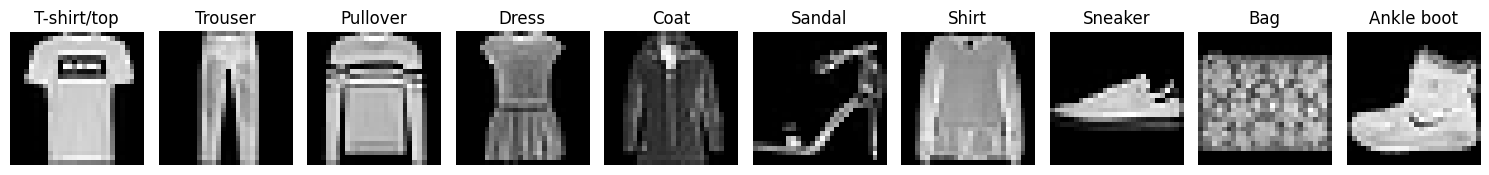

In [ ]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import fashion_mnist

class FashionMNISTLoader:
    def __init__(self):
        # You can rename or change class names as needed
        self.class_names = [
            'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
        ]

    def load_data(self):
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

        # Normalize pixel values to [0,1]
        x_train = x_train / 255.0
        x_test = x_test / 255.0

        return x_train, y_train, x_test, y_test

class FashionMNISTVisualizer:
    def __init__(self, class_names):
        self.class_names = class_names

    def plot_samples(self, x, y):
        """
        Plots one sample from each class in a single row of subplots.
        Returns a matplotlib Figure object that can be logged to wandb.
        """
        num_classes = len(self.class_names)
        fig, axes = plt.subplots(1, num_classes, figsize=(15, 3))

        for i in range(num_classes):
            # Find the first index in y where the label is i
            idx = np.where(y == i)[0][0]
            axes[i].imshow(x[idx], cmap='gray')
            axes[i].set_title(self.class_names[i])
            axes[i].axis('off')

        plt.tight_layout()
        return fig

class WandbLogger:
    def __init__(self, project, run_name):
        wandb.login()
        self.run = wandb.init(project=project, name=run_name)

    def log_image(self, plt_obj, key="Question 1"):
        """
        Logs the given Matplotlib figure (plt_obj) as an image to wandb
        under the specified key.
        """
        wandb.log({key: wandb.Image(plt_obj)})

    def finish(self):
        wandb.finish()

def main():
    # 1. Load data
    data_loader = FashionMNISTLoader()
    x_train, y_train, x_test, y_test = data_loader.load_data()

    # 2. Create a visualizer and plot one sample image per class
    visualizer = FashionMNISTVisualizer(data_loader.class_names)
    plot_obj = visualizer.plot_samples(x_train, y_train)

    # 3. Initialize wandb logger
    logger = WandbLogger(
        project="cs24m037-iit-madras",
        run_name="Q1"
    )

    # 4. Log the image to wandb
    logger.log_image(plot_obj)

    # 5. Show the plot locally (optional)
    plt.show()

    # 6. Finish the wandb run
    logger.finish()

if __name__ == "__main__":
    main()
